<a href="https://colab.research.google.com/github/WenyiYao/cryptocurrency/blob/main/lstm_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import pandas as pd
import numpy as np

In [22]:
df = pd.read_json('USDC-ETH.json')
df.head()

,id,high,low,tvlUSD,txCount,volumeUSD,date,open,tick,close
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19251,1483.170696,1396.900687,2.517911e+08,11053,4.784684e+08,2022-09-16,1472.111248,203641,1433.463152
1,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19252,1476.144985,1402.098845,2.666791e+08,9014,2.088181e+08,2022-09-17,1433.463152,203394,1469.404359
2,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19253,1469.421851,1324.864844,2.485486e+08,10707,2.443570e+08,2022-09-18,1469.404359,204359,1334.321067
3,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19254,1392.051034,1274.907911,2.609486e+08,13410,3.697855e+08,2022-09-19,1334.321067,204053,1375.641442
4,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19255,1383.911802,1313.997663,2.540213e+08,11117,3.349061e+08,2022-09-20,1375.641442,204440,1322.192169


In [23]:
df = df.drop(columns=["id"])
df = df.set_index(['date'])
df.head()

,high,low,tvlUSD,txCount,volumeUSD,open,tick,close
date,,,,,,,,
2022-09-16,1483.170696,1396.900687,2.517911e+08,11053,4.784684e+08,1472.111248,203641,1433.463152
2022-09-17,1476.144985,1402.098845,2.666791e+08,9014,2.088181e+08,1433.463152,203394,1469.404359
2022-09-18,1469.421851,1324.864844,2.485486e+08,10707,2.443570e+08,1469.404359,204359,1334.321067
2022-09-19,1392.051034,1274.907911,2.609486e+08,13410,3.697855e+08,1334.321067,204053,1375.641442
2022-09-20,1383.911802,1313.997663,2.540213e+08,11117,3.349061e+08,1375.641442,204440,1322.192169


In [24]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df['open'],
                                     high=df['high'],
                                     low=df['low'],
                                     close=df['close'])])
fig.show()

In [25]:
dataset = df.values
dataset

array([[1.48317070e+03, 1.39690069e+03, 2.51791059e+08, ...,
        1.47211125e+03, 2.03641000e+05, 1.43346315e+03],
       [1.47614498e+03, 1.40209885e+03, 2.66679134e+08, ...,
        1.43346315e+03, 2.03394000e+05, 1.46940436e+03],
       [1.46942185e+03, 1.32486484e+03, 2.48548636e+08, ...,
        1.46940436e+03, 2.04359000e+05, 1.33432107e+03],
       ...,
       [1.91744262e+03, 1.87164646e+03, 4.21586684e+08, ...,
        1.89410228e+03, 2.00821000e+05, 1.90038819e+03],
       [1.90651873e+03, 1.85254812e+03, 4.21238435e+08, ...,
        1.90038819e+03, 2.00893000e+05, 1.88681227e+03],
       [1.90372155e+03, 1.87535372e+03, 4.25635507e+08, ...,
        1.88681227e+03, 2.00841000e+05, 0.00000000e+00]])

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [27]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+1:(i+look_back+1),[0,1,7]]) #predict high, low, and close
    return numpy.array(dataX), numpy.array(dataY)

In [28]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [29]:
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [30]:
print(trainX.shape)
print(trainY.shape)

(288, 4, 8)
(288, 4, 3)


In [31]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

In [79]:
batch_size = 8
model0 = Sequential()
model0.add(LSTM(6, batch_input_shape=(batch_size, look_back, 8), stateful=True, return_sequences=True))
model0.add(TimeDistributed(Dense(3)))
model0.compile(loss='mean_squared_error', optimizer='adam')

all_history = []
test_loss_history = []

for i in range(25):
    # Train the model and store the history in the list
    history = model0.fit(trainX, trainY, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)
    all_history.append(history)

    # Evaluate the model on the test set and store the test loss
    test_loss = model0.evaluate(testX, testY, batch_size=batch_size)
    test_loss_history.append(test_loss)

    # Reset states for the next iteration
    model0.reset_states()

Epoch 1/10
36/36 - 2s - loss: 0.4000 - 2s/epoch - 63ms/step
Epoch 2/10
36/36 - 0s - loss: 0.2066 - 89ms/epoch - 2ms/step
Epoch 3/10
36/36 - 0s - loss: 0.0887 - 101ms/epoch - 3ms/step
Epoch 4/10
36/36 - 0s - loss: 0.0397 - 92ms/epoch - 3ms/step
Epoch 5/10
36/36 - 0s - loss: 0.0206 - 85ms/epoch - 2ms/step
Epoch 6/10
36/36 - 0s - loss: 0.0128 - 88ms/epoch - 2ms/step
Epoch 7/10
36/36 - 0s - loss: 0.0098 - 83ms/epoch - 2ms/step
Epoch 8/10
36/36 - 0s - loss: 0.0086 - 86ms/epoch - 2ms/step
Epoch 9/10
36/36 - 0s - loss: 0.0080 - 87ms/epoch - 2ms/step
Epoch 10/10
36/36 - 0s - loss: 0.0075 - 86ms/epoch - 2ms/step
16/16 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 1/10
36/36 - 0s - loss: 0.0066 - 86ms/epoch - 2ms/step
Epoch 2/10
36/36 - 0s - loss: 0.0069 - 90ms/epoch - 2ms/step
Epoch 3/10
36/36 - 0s - loss: 0.0065 - 89ms/epoch - 2ms/step
Epoch 4/10
36/36 - 0s - loss: 0.0062 - 87ms/epoch - 2ms/step
Epoch 5/10
36/36 - 0s - loss: 0.0059 - 96ms/epoch - 3ms/step
Epoch 6/10
36/36

In [80]:
model0.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (8, 4, 6)                 360       
                                                                 
 time_distributed_5 (TimeDi  (8, 4, 3)                 21        
 stributed)                                                      
                                                                 
Total params: 381 (1.49 KB)
Trainable params: 381 (1.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


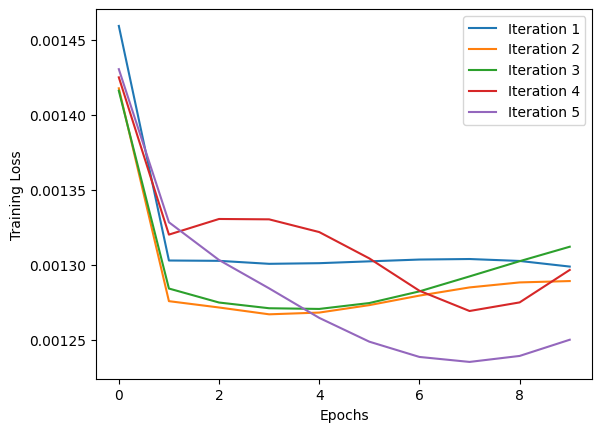

In [81]:
import matplotlib.pyplot as plt

# Assuming all_history is a list containing training history objects for each iteration
# Iterate through the list and plot the training loss for each iteration
for i, history in enumerate(all_history[20:26]):
    plt.plot(history.history['loss'], label=f'Iteration {i+1}')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

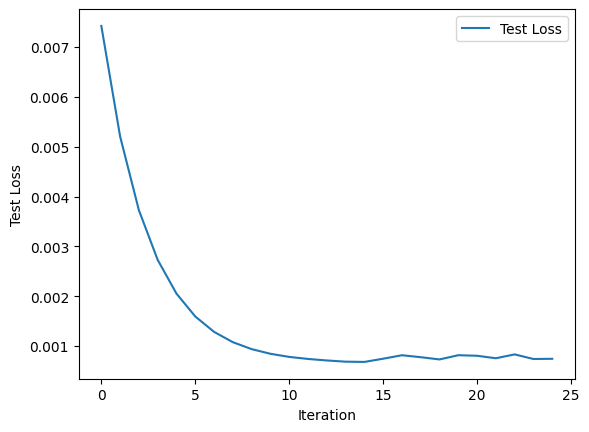

In [82]:
# Plot the test loss history
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Test Loss')
plt.legend()
plt.show()

In [83]:
trainPredict = model0.predict(trainX, batch_size=batch_size)
trainScore = math.sqrt(mean_squared_error(trainX[:, -1, 0], trainPredict[:, -1, 0]))
print('Train Score of high value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(trainX[:, -1, 1], trainPredict[:, -1, 1]))
print('Train Score of low value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(trainX[:, -1, 2], trainPredict[:, -1, 2]))
print('Train Score of close value: %.10f RMSE' % (trainScore))
model0.reset_states()

36/36 [==============================] - 1s 3ms/step
Train Score of high value: 0.0273527241 RMSE
Train Score of low value: 0.0286512665 RMSE
Train Score of close value: 0.3184910473 RMSE


In [84]:
testPredict = model0.predict(testX, batch_size=batch_size)
testScore = math.sqrt(mean_squared_error(testY[:, -1, 0], testPredict[0:testY.shape[0], -1, 0]))
print('Test Score of high value: %.2f RMSE' % (testScore))
trainScore = math.sqrt(mean_squared_error(testY[:, -1, 1], testPredict[0:testY.shape[0], -1, 1]))
print('Test Score of low value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(testY[:, -1, 2], testPredict[0:testY.shape[0], -1, 2]))
print('Test Score of close value: %.10f RMSE' % (trainScore))

16/16 [==============================] - 1s 3ms/step
Test Score of high value: 0.03 RMSE
Test Score of low value: 0.0474441340 RMSE
Test Score of close value: 0.0238027685 RMSE


In [85]:
print(trainPredict.shape)
print(trainY.shape)

(288, 4, 3)
(288, 4, 3)


In [86]:
print(testPredict.shape)
print(testY.shape)

(128, 4, 3)
(121, 4, 3)


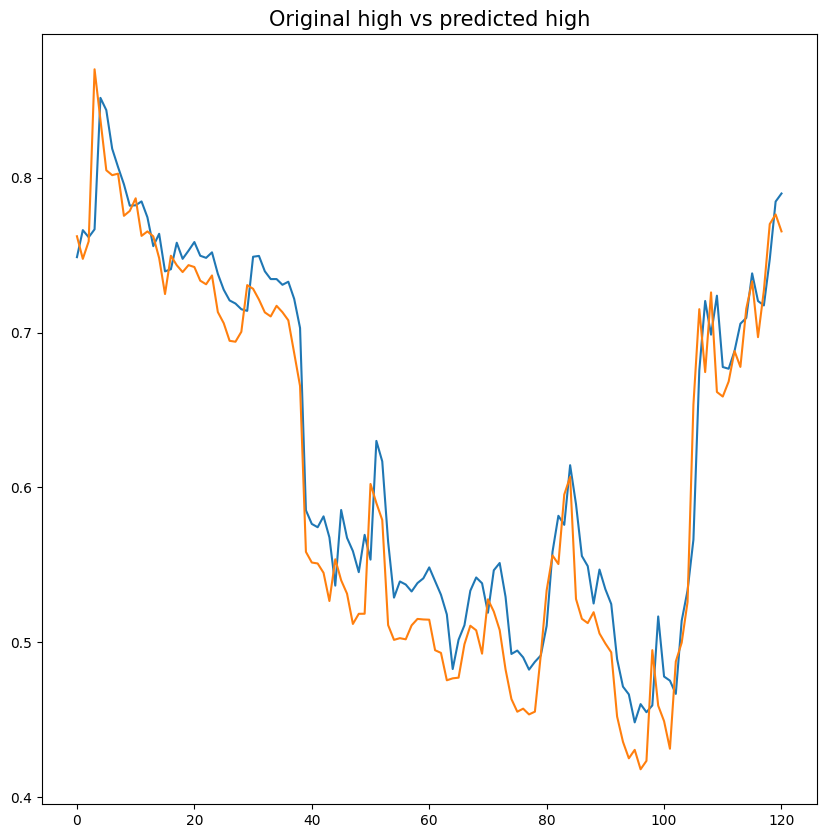

In [87]:
#testY=testY.reshape(-1,1)
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], -1, 0])
plt.plot(testY[:, -1, 0])
plt.title('Original high vs predicted high', fontsize=15)
plt.show()

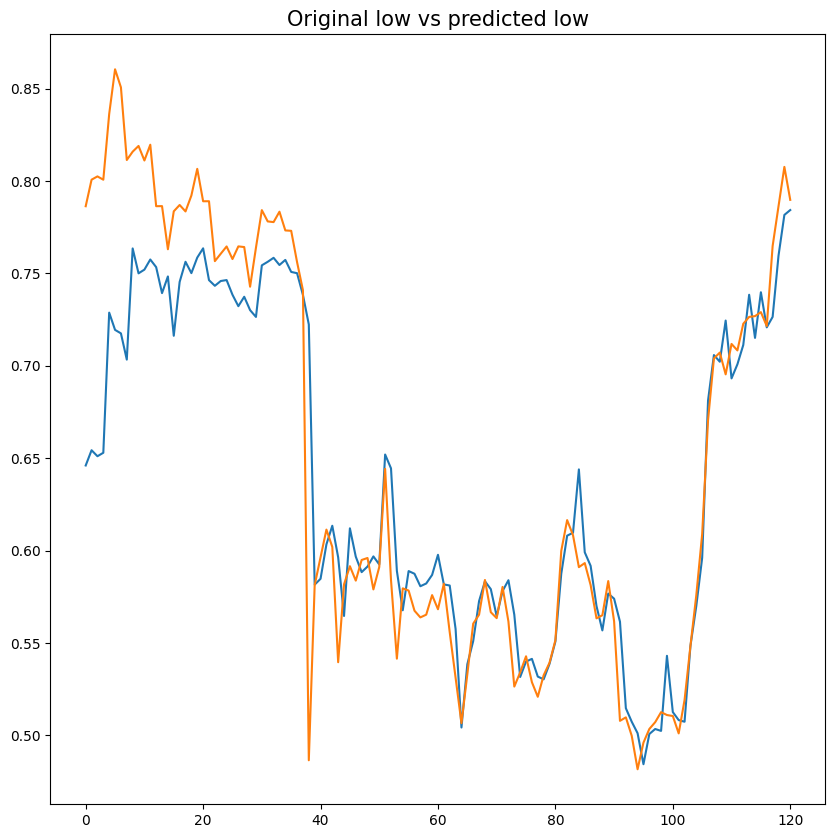

In [88]:
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], -1, 1])
plt.plot(testY[:, -1, 1])
plt.title('Original low vs predicted low', fontsize=15)
plt.show()

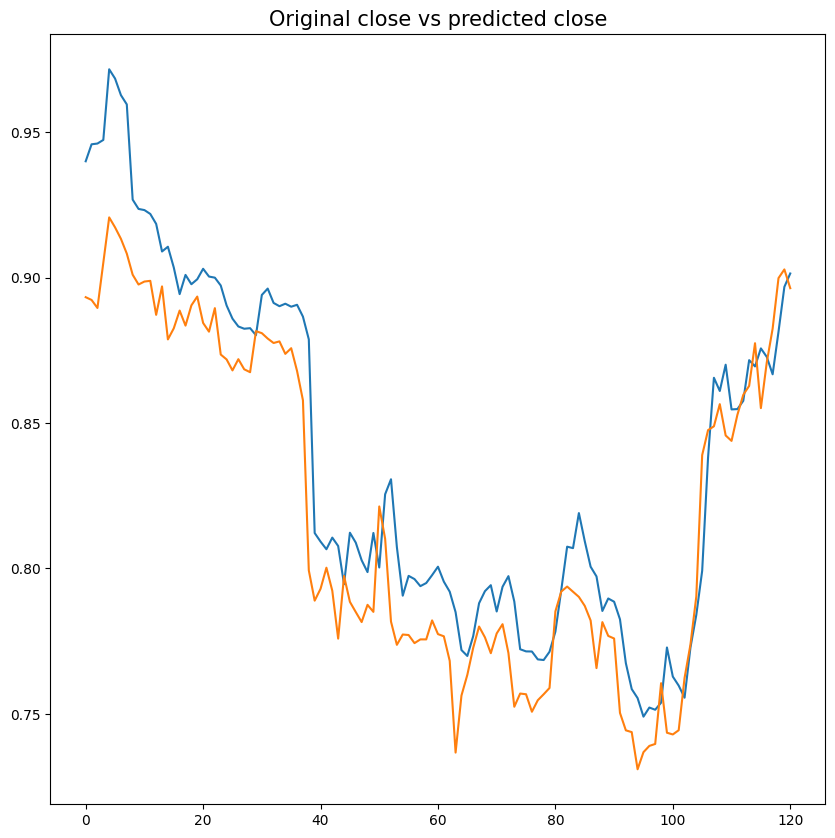

In [89]:
#testY=testY.reshape(-1,1)
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], -1, 2])
plt.plot(testY[:, -1, 2])
plt.title('Original close vs predicted close', fontsize=15)
plt.show()

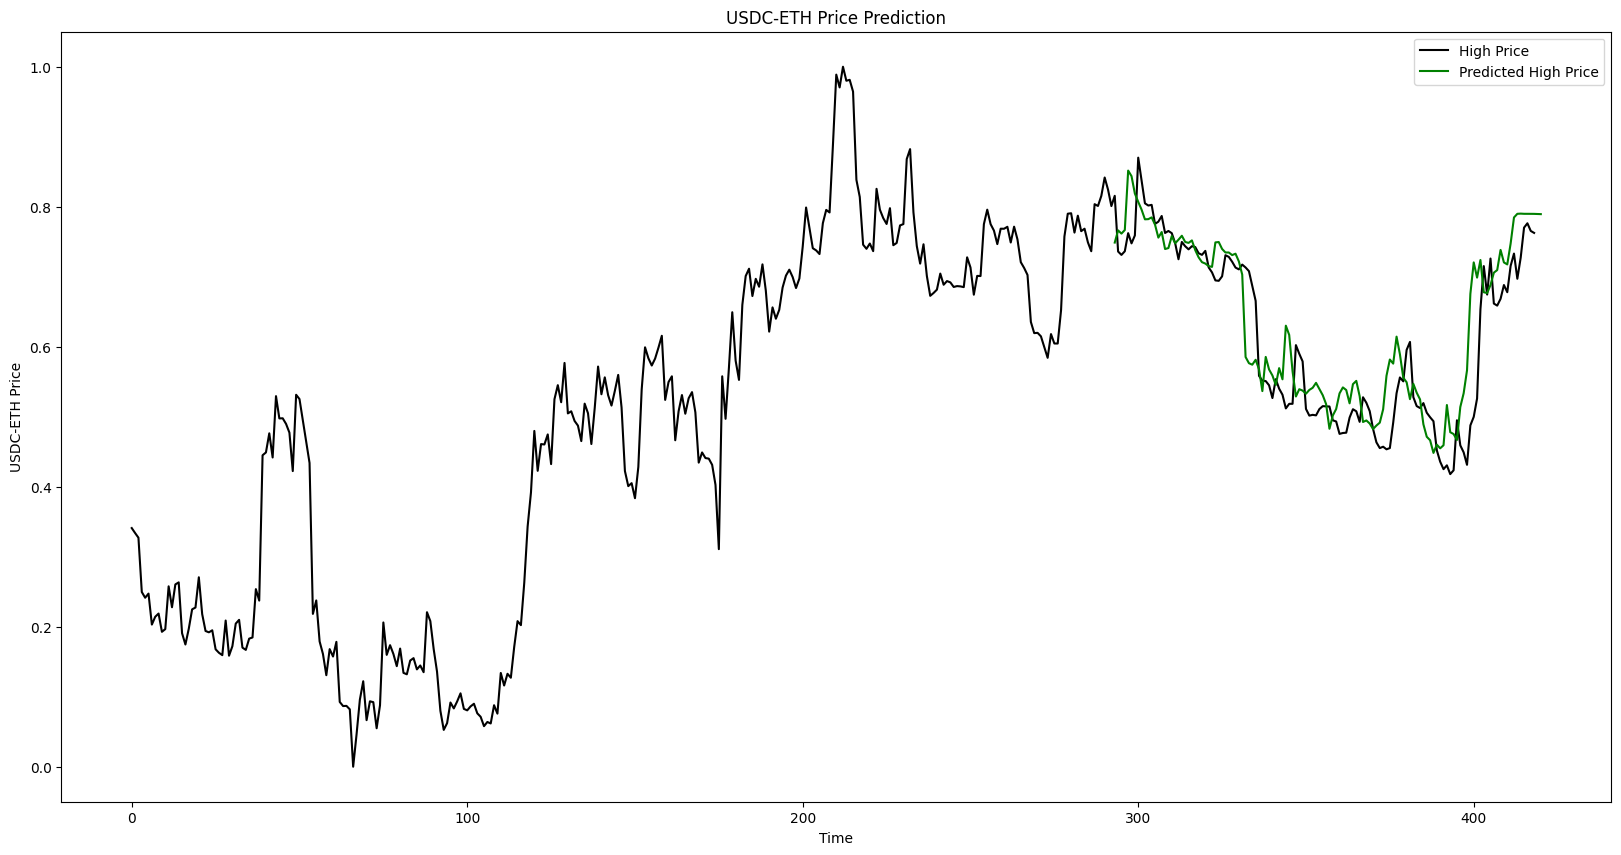

In [93]:
date_index = train_size
plt.figure(figsize=(20, 10))
plt.plot(dataset[:,0], color = 'black', label = 'High Price')
plt.plot(range(date_index, date_index + len(testPredict)), testPredict[:, -1, 0], color = 'green', label = 'Predicted High Price')
plt.title('USDC-ETH Price Prediction')
plt.xlabel('Time')
plt.ylabel('USDC-ETH Price')
plt.legend()
plt.show()